In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


SyntaxError: future feature annotations is not defined (se3_op.py, line 1)

In [108]:
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t

In [109]:
def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()

In [110]:
def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

In [111]:
def rotation_matrix(axis, theta):
    axis = axis/np.sqrt(np.dot(axis, axis))
    a = np.cos(theta/2.)
    b, c, d = -axis*np.sin(theta/2.)

    return np.array([[a*a+b*b-c*c-d*d, 2*(b*c-a*d), 2*(b*d+a*c)],
                  [2*(b*c+a*d), a*a+c*c-b*b-d*d, 2*(c*d-a*b)],
                  [2*(b*d-a*c), 2*(c*d+a*b), a*a+d*d-b*b-c*c]])

In [112]:
def visualize_point_cloud(A, B, title_A='Original', title_B='Transformed'):
    fig = plt.figure(figsize=(10, 5))

    # Plotting original point cloud
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(A[:, 0], A[:, 1], A[:, 2], c='b', label=title_A)
    ax1.set_title(title_A)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.legend()

    # Plotting transformed point cloud
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(B[:, 0], B[:, 1], B[:, 2], c='r', label=title_B)
    ax2.set_title(title_B)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.legend()

    plt.show()

In [113]:
# Constants
N = 100                                    # number of random points in the dataset
num_tests = 100                             # number of test iterations
dim = 3                                     # number of dimensions of the points
noise_sigma = .01                           # standard deviation error to be added
translation = .1                            # max translation of the test set
rotation = .1                               # max rotation (radians) of the test set

def test_best_fit():

    # Generate a random dataset
    A = np.random.rand(N, dim)

    total_time = 0

    for i in range(num_tests):

        B = np.copy(A)

        # Translate
        t = np.random.rand(dim)*translation
        B += t

        # Rotate
        R = rotation_matrix(np.random.rand(dim), np.random.rand()*rotation)
        B = np.dot(R, B.T).T

        # Add noise
        B += np.random.randn(N, dim) * noise_sigma

        # Find best fit transform
        start = time.time()
        T, R1, t1 = best_fit_transform(B, A)
        total_time += time.time() - start

        # Make C a homogeneous representation of B
        C = np.ones((N, 4))
        C[:,0:3] = B

        # Transform C
        C = np.dot(T, C.T).T
        
        assert np.allclose(C[:,0:3], A, atol=6*noise_sigma) # T should transform B (or C) to A
        assert np.allclose(-t1, t, atol=6*noise_sigma)      # t and t1 should be inverses
        assert np.allclose(R1.T, R, atol=6*noise_sigma)     # R and R1 should be inverses
    visualize_point_cloud(A, C, title_A='Original', title_B='Transformed')
    print('best fit time: {:.3}'.format(total_time/num_tests))

    return


def test_icp():

    # Generate a random dataset
    A = np.random.rand(N, dim)

    total_time = 0

    for i in range(num_tests):

        B = np.copy(A)

        # Translate
        t = np.random.rand(dim)*translation
        B += t

        # Rotate
        R = rotation_matrix(np.random.rand(dim), np.random.rand() * rotation)
        B = np.dot(R, B.T).T

        # Add noise
        B += np.random.randn(N, dim) * noise_sigma

        # Shuffle to disrupt correspondence
        np.random.shuffle(B)

        # Run ICP
        start = time.time()
        T, distances, iterations = icp(B, A, tolerance=0.000001)
        total_time += time.time() - start

        # Make C a homogeneous representation of B
        C = np.ones((N, 4))
        C[:,0:3] = np.copy(B)

        # Transform C
        C = np.dot(T, C.T).T
        
        assert np.mean(distances) < 6*noise_sigma                   # mean error should be small
        assert np.allclose(T[0:3,0:3].T, R, atol=6*noise_sigma)     # T and R should be inverses
        assert np.allclose(-T[0:3,3], t, atol=6*noise_sigma)        # T and t should be inverses
    visualize_point_cloud(A, C, title_A='Original', title_B='Transformed')
    print('icp time: {:.3}'.format(total_time/num_tests))

    return





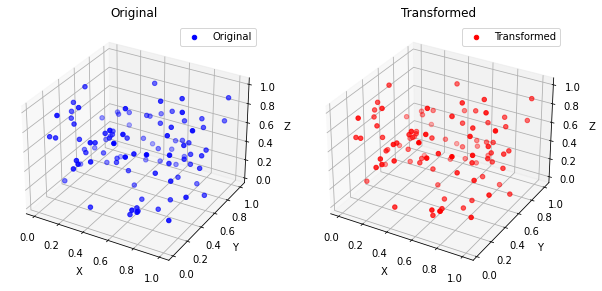

best fit time: 0.00011


In [114]:
test_best_fit()

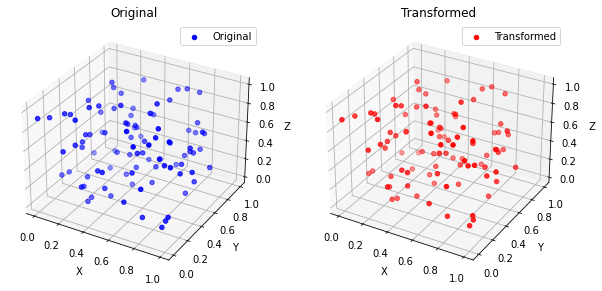

icp time: 0.00416


In [115]:
test_icp()

NameError: name 'cpd' is not defined